In [0]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# 필요한 파일들 읽음
faceDetector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor("data/models/shape_predictor_68_face_landmarks.dat")

im = cv2.imread('data/images/two-women-face.jpg')  # input image = im
    
# Detect faces in the image
faceRects = faceDetector(im, 1)
print("image :", im.shape, "    {} faces detected: ".format(len(faceRects)))

image : (363, 500, 3)     2 faces detected: 


Text(0.5, 1.0, 'face blur')

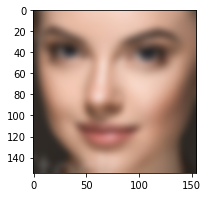

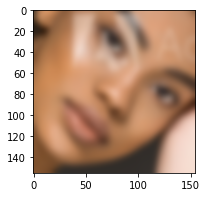

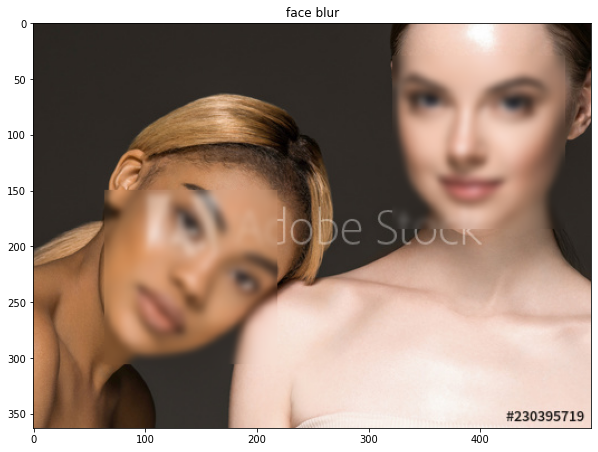

In [37]:
# project #1 : 얼굴 부분을 블러링 처리
im_copy = im.copy()
for i in range(0, len(faceRects)):
    x1 = faceRects[i].left()
    y1 = faceRects[i].top()
    x2 = faceRects[i].right()
    y2 = faceRects[i].bottom()

    im_face = im_copy[y1:y2+1, x1:x2+1]
    im_face_blur = cv2.GaussianBlur(im_face, (0, 0), 3)
    im_copy[y1:y2+1, x1:x2+1] = im_face_blur

    plt.figure(figsize=(3,3))
    plt.imshow(im_face_blur[:,:,::-1])
    
plt.figure(figsize=(10,10))
plt.imshow(im_copy[:,:,::-1]); plt.title('face blur')

In [0]:
def smile_detector(landmarks):
    isSmiling = False
    lipWidth = np.sqrt((landmarks.part(51).x-landmarks.part(57).x)*
                       (landmarks.part(51).x-landmarks.part(57).x) + 
                       (landmarks.part(51).y-landmarks.part(57).y)*
                       (landmarks.part(51).y-landmarks.part(57).y) )
    jawWidth = np.sqrt((landmarks.part(8).x-landmarks.part(57).x)*
                       (landmarks.part(8).x-landmarks.part(57).x) + 
                       (landmarks.part(8).y-landmarks.part(57).y)*
                       (landmarks.part(8).y-landmarks.part(57).y) )
    thres = 0.4
    
    if lipWidth / jawWidth >= thres :
        isSmiling = True
    return isSmiling

Text(0.5, 1.0, 'Smile text')

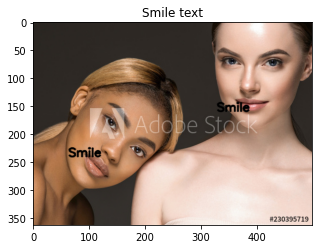

In [61]:
# project #2 : 웃는 얼굴 입술 왼쪽 끝에 'Smile' 이라고 적음
im_copy = im.copy()
for i in range(0, len(faceRects)):
  landmarks = landmarkDetector(im_copy, faceRects[i])
  smileFlag = smile_detector(landmarks)
  if smileFlag :
     cv2.putText(im_copy, "Smile", (landmarks.part(2).x , landmarks.part(5).y ), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, cv2.LINE_AA)
plt.figure(figsize=(5,5))
plt.imshow(im_copy[:,:,::-1]); plt.title("Smile text")

Text(0.5, 1.0, 'heart emoji on smile face')

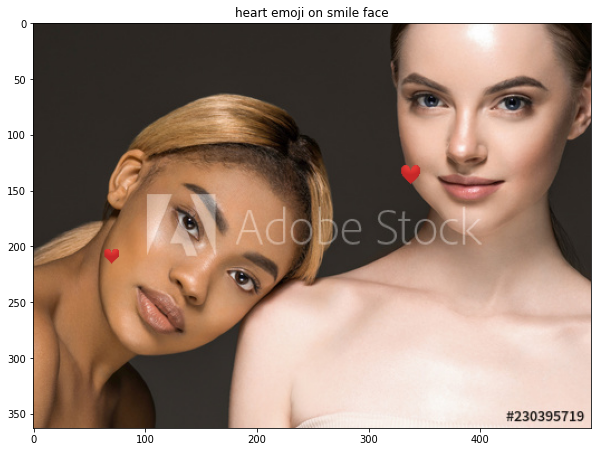

In [80]:
# project #3 : 웃는 얼굴 입술 왼쪽 끝에  heart-icon 넣음
#  icon 크기는 높이가 윗입술과 아랫입술 사이 거리(랜드마크 57과 51의 거리)와 같게하고,
#              폭은 원래 icon파일의 가로 세로 비가 유지되도록 하기 바람

im_copy = im.copy()

# heart-icon 파일 읽어 마스크 구함
emoji_image = cv2.imread('data/images/heart-icon.png')  # emoji_image
image_gray = cv2.cvtColor(emoji_image, cv2.COLOR_BGR2GRAY)
_,e_mask = cv2.threshold(image_gray, 150, 255, cv2.THRESH_BINARY_INV) # emoji_mask
emoji_mask = cv2.merge((e_mask, e_mask, e_mask))
emoji_masked_image = cv2.bitwise_and(emoji_image, emoji_mask)
eh, ew = emoji_masked_image.shape[:2]

for i in range(0, len(faceRects)):
  # For every face rectangle, run landmarkDetector
  landmarks = landmarkDetector(im_copy, faceRects[i])
  smileFlag = smile_detector(landmarks)
  if smileFlag :
    lip_h = landmarks.part(57).y - landmarks.part(51).y
    w = np.int(ew * (lip_h / eh))
    emoji_small = cv2.resize(emoji_masked_image, (w, lip_h))
    emoji_mask_small = cv2.resize(emoji_mask, (w, lip_h))
    x1 = landmarks.part(2).x
    y1 = landmarks.part(3).y
    
    subimage = im_copy[y1:y1+lip_h, x1:x1+w] * (1-emoji_mask_small / 255)
    subimage = subimage.astype(np.uint8)
   
    
    im_copy[y1:y1+lip_h, x1:x1+w] = subimage + emoji_small
plt.figure(figsize=(10,10))
plt.imshow(im_copy[:,:,::-1]); plt.title("heart emoji on smile face")

s_mask, s_masked_image : (480, 960, 3) (480, 960, 3)


Text(0.5, 1.0, 'result')

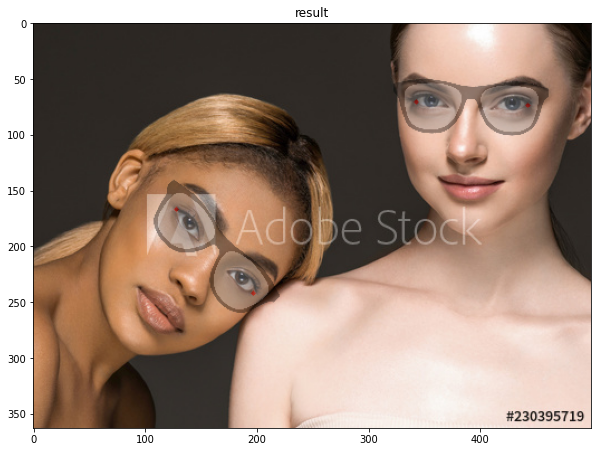

In [91]:
# project #4 : 얼굴에 썬글라스 씌우기

im_copy = im.copy()
h, w = im_copy.shape[:2]

# sunglasses 파일 읽어 마스크 구함
s_image = cv2.imread('data/images/sunglasses.png')  # sunglasses_image

image_gray = cv2.cvtColor(s_image, cv2.COLOR_BGR2GRAY)
_,e_mask = cv2.threshold(image_gray, 200, 255, cv2.THRESH_BINARY_INV) # sunglasses_mask
s_mask = cv2.merge((e_mask, e_mask, e_mask))
s_masked_image = cv2.bitwise_and(s_image, s_mask)
sh, sw = s_masked_image.shape[:2]
print('s_mask, s_masked_image :', s_mask.shape, s_masked_image.shape)

ree_x = np.int(sw*0.15);  lee_x = np.int(sw*(1-0.13))  # right(left) eye endpoint x
ee_y = np.int(sh*0.45)  # eyes endpoint y
eyecornerSrc = [(ree_x, ee_y), (lee_x, ee_y)]
cv2.circle(s_masked_image, eyecornerSrc[0], int(sh*0.03), (0,0,255), -1)
cv2.circle(s_masked_image, eyecornerSrc[1], int(sh*0.03), (0,0,255), -1)


# im_copy와 같은 크기 zero 영상 만듦.   안경 마스크, 영상을 중첩시킬 예정
s_maskDst = np.zeros_like(im_copy)
s_maskedImageDst = np.zeros_like(im_copy)

for i in range(0, len(faceRects)):

    landmarks = landmarkDetector(im_copy, faceRects[i])
    point2 = (landmarks.part(36).x, landmarks.part(36).y) 
    point0 = (landmarks.part(45).x, landmarks.part(45).y) 
    eyecornerDst = [point2, point0]
  
  
    ret = cv2.estimateAffinePartial2D(np.array([eyecornerSrc]), np.array([eyecornerDst]))
    xform = ret[0]
   

    xformed_mask = cv2.warpAffine(s_mask, xform, (w, h))
    xformed_maskedImage = cv2.warpAffine(s_masked_image, xform, (w, h))

    
    s_maskDst = s_maskDst + xformed_mask
    s_maskedImageDst = s_maskedImageDst + xformed_maskedImage
    

dst_blend = (im_copy*0.7+ s_maskedImageDst*0.3).astype(np.uint8) 
s_mask_float = s_maskDst / 200
s_mask_Invert = 1-s_maskDst
dst_object = (dst_blend * s_mask_float).astype(np.uint8)
dst_background = (im_copy * (1-s_mask_float)).astype(np.uint8)
dst_total = dst_object + dst_background
plt.figure(figsize=(10,10))
plt.imshow(dst_total[:,:,::-1]);  plt.title('result')